# Neural ODE

1. Setup and Data Preparation

In [560]:
import torch
import torch.nn as nn
import numpy as np
import sklearn
from torch import Tensor
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics.classification import BinaryPrecisionRecallCurve
from torchmetrics.classification import BinaryAccuracy
from tqdm.auto import tqdm
from sklearn.metrics import auc
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
import seaborn as sns
from plotly.subplots import make_subplots

In [561]:
def train_model(
    model,
    data_loader,
    loss_fn,
    optimizer,
    verbose=False,
):
    """
    Training loop for 1 epoch

    Args:
        model (_type_): _description_
        data_loader (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
    """
    train_loss = 0.0 # keep track of total loss
    train_acc = 0.0 # keep track of the total accuracy

    # print(len(data_loader))
    for batch, (X_data, y_data) in enumerate(data_loader):
        model.train() # Set to training mode
        # Forward pass - make a prediction
        # print("before fp")
        y_prob, x_transformed = model(X_data) # (model outputs probabilities)
        # print("after fp")
        y_pred = torch.round(y_prob) # (probabilities -> binary prediction)
        # note: perform sigmoid on the "logits" dimension, not "batch" dimension 
        # (in this case we have a batch size of 1, so can perform on dim=0)
        # print(f"batch: {batch}")
        # Compute the loss
        # print(y_prob)
        # print(y_data)
        loss = loss_fn(y_prob, y_data)
        train_loss += loss
        if y_pred.shape == y_data.shape:
            acc = torch.eq(y_pred, y_data).sum().item() / len(y_data) * 100
        else:
            acc = torch.eq(y_pred.argmax(dim=1), y_data).sum().item() / len(y_data) * 100
        train_acc += acc
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Compute gradient of the loss w.r.t. to the parameters 
        loss.backward()
        
        # Optimizer will modify the parameters by consideting the gradient
        # Inside each parameter there is already a grad calculated, 
        # this applies the optimizer algorithm to the observed parameters
        optimizer.step()
        
        # Print out how many samples have been seen
        if verbose:
            if batch % 400 == 0:
                print(f"Looked at {batch * len(X_data)}/{len(data_loader.dataset)} samples")
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    return train_loss, train_acc
    
def test_model(
    model,
    data_loader,
    loss_fn,
    evaluate=False
):
    test_loss = 0.0 # keep track of total loss
    test_acc = 0.0 # keep track of the total accuracy
    x_transformed_array = []
    y_transformed_array = []
    
    model.eval() # Set to evaluation mode
    
    with torch.inference_mode(): # Turn on inference context manager
        for X_test, y_test in data_loader:
            
            # Forward pass - Inference data
            y_prob, x_transformed = model(X_test) # (model outputs probabilities)
            y_pred = torch.round(y_prob) # (probabilities -> binary prediction)
            # note: perform sigmoid on the "logits" dimension, not "batch" dimension 
            # (in this case we have a batch size of 1, so can perform on dim=0)
            
            
            # Compute loss and accuracy
            loss = loss_fn(y_pred, y_test)
            if y_pred.shape == y_test.shape:
                acc = torch.eq(y_pred, y_test).sum().item() / len(y_test) * 100
            else:
                acc = torch.eq(y_pred.argmax(dim=1), y_test).sum().item() / len(y_test) * 100
            test_loss += loss
            test_acc += acc
            
            # Save intermidiate state
            x_transformed_array.append(x_transformed)
            y_transformed_array.append(y_test)
            
        # Print metrics
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        if evaluate == True:
            return (
                {"model_name": model.__class__.__name__,
                "model_loss": test_loss.item(),
                "model_acc": test_acc},
                x_transformed_array,
                y_transformed_array
            )

        else:
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    return test_loss, test_acc

def make_predictions(model, data):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension and send sample to device

            # Forward pass (model outputs probability)
            pred_prob = model(sample)
            
            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

# Confusion matrix
def compute_confusion_matrix(model, dataset, data_loader):
    
    # Make predictions with trained model
    y_probs = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader, desc="Making predictions"):
            # Do the forward pass
            y_prob, x_transformed = model(X)

            y_probs.append(y_prob)
        
    # Concatenate list of predictions into a tensor
    y_probs_tensor = torch.cat(y_probs)
    
    # Setup confusion matrix instance and compare predictions to targets
    confmat = ConfusionMatrix(num_classes=len(dataset.classes), task='multiclass')
    confmat_tensor = confmat(preds=y_probs_tensor,
                            target=dataset.targets)
    return confmat_tensor

# Plot decision boundaries for training and test sets
def decision_boundary_grid(model, X, y):
    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make points
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions on grid
    model.eval()
    with torch.inference_mode():
        y_grid_probs, x_transformed = model(X_to_pred_on)
        
    # Test for multi-class or binary and adjust logits to prediction labels
    y_grid_pred = torch.round(y_grid_probs)  # binary
    
    # Reshape to 2D
    y_grid_pred = y_grid_pred.reshape(xx.shape).numpy()
    
    return xx, yy, y_grid_pred


def get_dataloader_from_numpy_dataset(X, y):
    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)
        
    print(f"Shape of synthetic dataset (X, y): {X.shape, y.shape}")
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Synthetic dataset")
    plt.show()

    # Train test split dataset
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, # 20% test, 80% train
                                                        random_state=42) # make the random split reproducible 

    # Create a data loader from the dataset
    train_data = TensorDataset( X_train, y_train)
    test_data = TensorDataset( X_test, y_test)
    BATCH_SIZE = 5

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True # shuffle data every epoch
    )
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=400,
    )

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    scatter = axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, label=y_train)
    legend0 = axs[0].legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    axs[0].add_artist(legend0)
    axs[0].set_title("train dataset")
    axs[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, label=y_test)
    axs[1].set_title("test dataset")
    legend1 = axs[1].legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    axs[1].add_artist(legend1)

    plt.suptitle("Train-test split")
    plt.show()
    
    return train_dataloader, test_dataloader, train_data, test_data, X_train, y_train, X_test, y_test

def generate_spiral_data(n_points, noise=0.5):
    n = np.sqrt(np.random.rand(n_points, 1)) * 360 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.randn(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.randn(n_points, 1) * noise
    return (np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))), 
            np.hstack((np.zeros(n_points), np.ones(n_points))))

Cloud data

Shape of synthetic dataset (X, y): (torch.Size([4000, 2]), torch.Size([4000]))


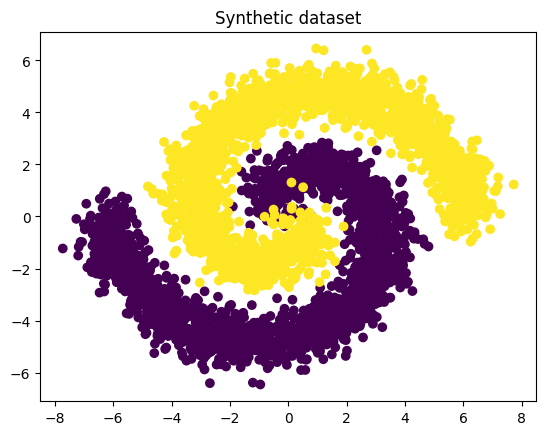

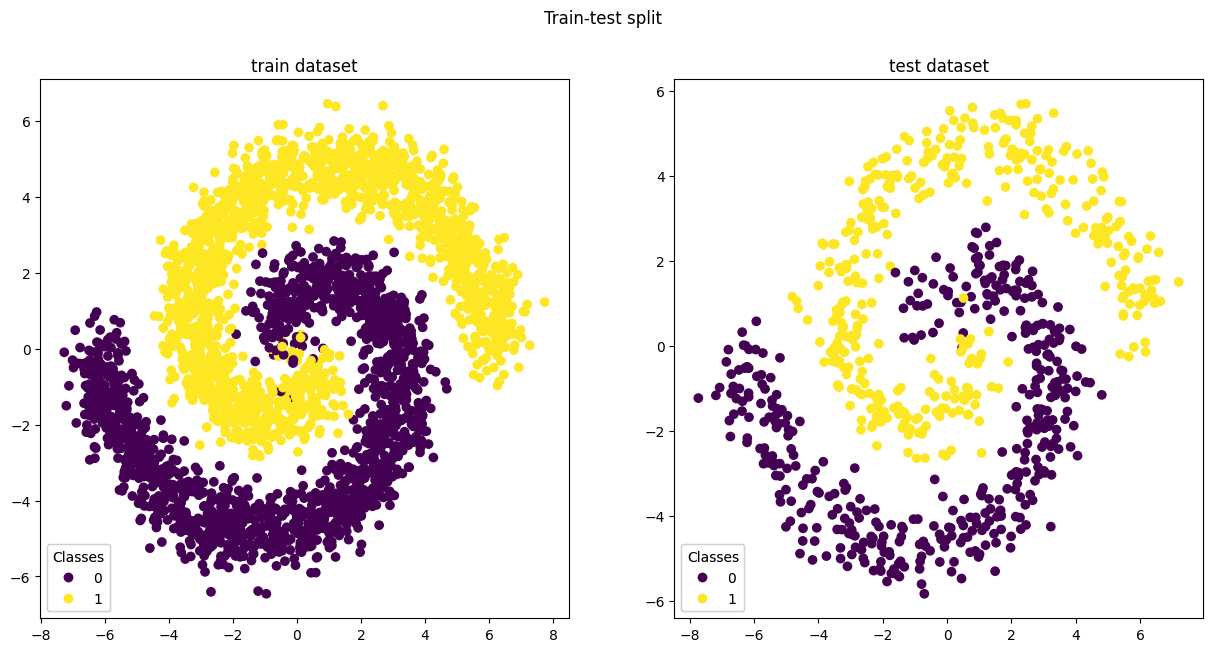

In [585]:
n_points = 2000
X, y = generate_spiral_data(n_points)

train_dataloader, test_dataloader, train_data, test_data, X_train, y_train, X_test, y_test = get_dataloader_from_numpy_dataset(X, y)

# plt.figure(figsize=(10, 10))
# plt.scatter(X[y==0, 0], X[y==0, 1], color='red', label='Class 0')
# plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', label='Class 1')
# plt.title("Spiral Test Data")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.legend()
# plt.show()


Circle data

In [586]:
# # Make 1000 samples 
# n_samples = 1000

# # Create circles
# X, y = make_circles(n_samples, # Make a large circle containing a smaller circle in 2d
#                     noise=0.05, # a little bit of noise to the dots
#                     random_state=42) # keep random state so we get the same values

# train_dataloader, test_dataloader, train_data, test_data, X_train, y_train, X_test, y_test = get_dataloader_from_numpy_dataset(X, y)

Get dim of data

In [587]:
# Get dim
input_dim = X.shape[-1] # image_dim # 
if len(y.shape) == 1:
    output_dim = 1
else:
    output_dim = y.shape[-1] # len(class_names) #

2. Neural ODE Implementation

In [588]:
class ODEBlock(nn.Module):
    """
    y' = dy/dt

    Args:
        nn (_type_): _description_
    """
    def __init__(self, variant, sigma, m, p=None):
        super(ODEBlock, self).__init__()
        self.variant = variant
        self.m = m
        self.p = p if p else m  # Default to m if p is None
        self.sigma = sigma # activation function

        if self.variant == 'standard':
            self.W = nn.Parameter(torch.randn(self.m, self.m))
            self.b = nn.Parameter(torch.randn(self.m))
        elif self.variant == 'UT':
            self.U = nn.Parameter(torch.randn(self.p, self.m))
            self.W = nn.Parameter(torch.randn(self.p, self.m))
            self.b = nn.Parameter(torch.randn(self.p))
        else:
            raise ValueError("Invalid variant type")

    def forward(self, y):
        # y shape : batch size x m
        
        if self.variant == 'standard':
            Wy = torch.mm(self.W, y.T).T
            b = torch.mul(torch.ones(y.shape[0], self.b.shape[0]),  self.b)
            return self.sigma(Wy + b) # torch.mm : matrix multiplication
        elif self.variant == 'UT':
            Wy = torch.mm(self.W, y.T).T
            b = torch.mul(torch.ones(y.shape[0], self.b.shape[0]),  self.b)
            # print(self.sigma(Wy + b).shape, self.U.shape)
            # print(Wy, b)
            return torch.mm(self.U.T, self.sigma(Wy + b).T).T

class NeuralODE(nn.Module):
    """
    
    FIXME: What about multiple steps?

    Args:
        nn (_type_): _description_
    """
    def __init__(self, input_dim, hidden_dim, hidden_internal_dim, output_dim, num_hidden_layers, sigma, method, variant):
        super(NeuralODE, self).__init__()
        self.method = method
        self.variant = variant
        self.num_hidden_layers = num_hidden_layers  # how many time steps
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_internal_dim = hidden_internal_dim
        self.output_dim = output_dim
        self.sigma = sigma()
        self.h = 0.05 # constant step size
        
        
        self.input_layer = nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=False)
        
        self.ode = ODEBlock(variant=variant, sigma=self.sigma, m=hidden_dim, p=hidden_internal_dim) # y'

        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )
        
        # logits to prob
        self.logits_to_prob = nn.Sequential(
            nn.Sigmoid()
        )
        
    def forward(self, x):
        
        # track transformation of the data
        # samples in batch - num hidden units - num hidden layers + 1 # FIXME: Do i need +1??
        x_transformed = torch.empty(x.shape[0], self.hidden_dim, self.num_hidden_layers + 1)
        
        # input layer (increase dimension) 
        x = self.input_layer(x)
        
        # save tranformation of x at time t0 (after dim increase)
        x_transformed[:, :, 0] = x
        
        # ODE solver
        for t in range(self.num_hidden_layers): # how many time steps
            if self.method == "neural":
                x = self.ode(x)
            elif self.method == "euler":
                x = x + self.h * self.ode(x)
            elif self.method == "rk4":
                k1 = self.ode(x)
                k2 = self.ode(x + self.h * k1 / 2.0)
                k3 = self.ode(x + self.h * k2 / 2.0)
                k4 = self.ode(x + self.h * k3)
            
                x = x + self.h * (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0
                
            else:
                raise ValueError("Invalid method type")
            
            # save tranformation of x for each time step
            x_transformed[:, :, t+1] = x
        
        # outout layers 
        # classifier to binary channel 
        # and from logits to probabilities
        x = self.classifier(x)
        x = self.logits_to_prob(x)
        
        return x.squeeze(), x_transformed

3. Training

In [597]:
# SET VARIABLES

activation_functions = [
    nn.ReLU,
    # nn.Sigmoid,
    # nn.SiLU,
    # nn.Tanh,
    # nn.ELU,
    # nn.Hardsigmoid,
    # nn.GELU,
]

# NOTE: hvis hidden dim er for stor, blir det da for vanskelig å plotte trajectory som "ligner" på slik input dataen er i 2D?
hidden_dim = 16

hidden_internal_dim = 16 # internal dim in y' : p in (p x m)
num_hidden_layers = 10 # number of time steps
method = ["neural", "euler", "rk4"][1]
variant = ["standard", "UT"][1]


# NOTE:
# med spiral dataset fungerer hidden_dim = 3, og man kan da plotte resultatet i 3d. Nettverket fungerer ikke for cirkel data.


# ut fungerer ikke med rk4, men fungerer fint med euler for cirkel data. Følgende separerer prikkene bra. Men hvorfor er de ikke alltid separert SELV OM modellen predikerer korrekt?
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][1]

# helt likt fungerer ikke for sprial data, men dersom man ender til standard metode fungerer det for spiral
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][0]


Activation function ReLU:

----> EPOCH 0 of 100:
Train loss: 0.72462 | Train accuracy: 80.28%
Test loss: 16.50000 | Test accuracy: 83.50%

----> EPOCH 1 of 100:
Train loss: 0.24273 | Train accuracy: 92.50%
Test loss: 3.25000 | Test accuracy: 96.75%

----> EPOCH 2 of 100:
Train loss: 0.12353 | Train accuracy: 96.06%
Test loss: 2.75000 | Test accuracy: 97.25%

----> EPOCH 3 of 100:
Train loss: 0.07855 | Train accuracy: 97.66%
Test loss: 3.87500 | Test accuracy: 96.12%

----> EPOCH 4 of 100:
Train loss: 0.06336 | Train accuracy: 98.06%
Test loss: 1.75000 | Test accuracy: 98.25%

----> EPOCH 5 of 100:
Train loss: 0.15337 | Train accuracy: 96.44%
Test loss: 7.37500 | Test accuracy: 92.62%

----> EPOCH 6 of 100:
Train loss: 0.05817 | Train accuracy: 98.22%
Test loss: 1.37500 | Test accuracy: 98.62%

----> EPOCH 7 of 100:
Train loss: 0.05477 | Train accuracy: 98.38%
Test loss: 1.37500 | Test accuracy: 98.62%

----> EPOCH 8 of 100:
Train loss: 0.05059 | Train accuracy: 98.72%
Test loss: 3.375

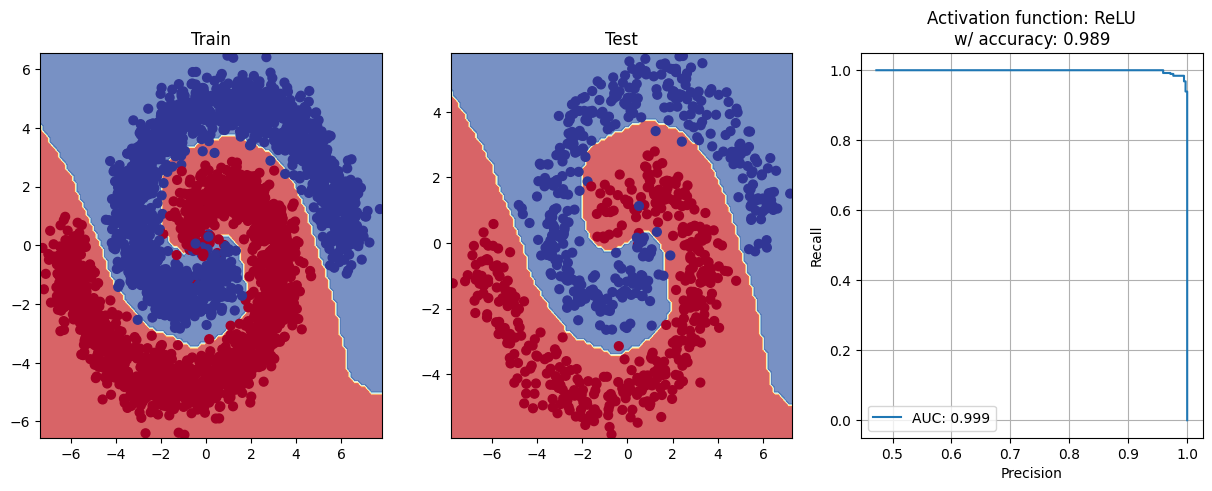

In [598]:
# Initialize plot for evaluation if we are comparing different actication function
if len(activation_functions) > 1:
    fig = plt.figure(constrained_layout=True, figsize=(15, 7*len(activation_functions)))
    axs = fig.subfigures(len(activation_functions), 1)

for a, activation_function in enumerate(activation_functions):
    try:
        print(f"\nActivation function {activation_function.__name__}:\n")
    except AttributeError:
        print(f"\nActivation function {activation_function}:\n")
    
    # Create 1x3 subplots on each row
    if len(activation_functions) > 1:
        subaxs = axs[a].subplots(1, 3)    
    else:
        fig, subaxs = plt.subplots(1, 3, figsize=(15, 5))   
    
    # Initialize model
    torch.manual_seed(42) # set seed for random parameters in model
    model = NeuralODE(
        input_dim=input_dim, 
        hidden_dim=hidden_dim, 
        hidden_internal_dim=hidden_internal_dim,
        output_dim=output_dim, 
        num_hidden_layers=num_hidden_layers, # num time steps
        sigma=activation_function,
        variant=variant,
        method=method)

    # Select optimizer and loss function
    loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in. Require inputs to have gone through the sigmoid activation function prior

    # Create an optimizer
    optimizer = torch.optim.SGD(
        params=model.parameters(), 
        lr=0.1
    )

    # Train and test for multiple epochs
    epochs = 100
    train_loss_per_epoch = []
    test_loss_per_epoch = []
    train_acc_per_epoch = []
    test_acc_per_epoch = []
    
    for epoch in range(epochs):
        print(f"----> EPOCH {epoch} of {epochs}:")
        train_loss, train_acc = train_model(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            verbose=False
        )
        # print("after train")
        test_loss, test_acc = test_model(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn
        )
        
        train_loss_per_epoch.append(train_loss.detach().numpy())
        train_acc_per_epoch.append(train_acc)
        
        test_loss_per_epoch.append(test_loss.detach().numpy())
        test_acc_per_epoch.append(test_acc)

    # Plot decision boundaries for training and test sets
    for i, kwargs in enumerate(zip([X_train.numpy(), X_test.numpy()], [y_train.numpy(), y_test.numpy()], ["Train", "Test"])):
        X_data, y_data, title = kwargs
        xx, yy, y_grid_pred = decision_boundary_grid(
            model=model,
            X=X_data,
            y=y_data
            )
        subaxs[i].contourf(xx, yy, y_grid_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
        subaxs[i].scatter(X_data[:, 0], X_data[:, 1], c=y_data, s=40, cmap=plt.cm.RdYlBu)
        subaxs[i].set_xlim(xx.min(), xx.max())
        subaxs[i].set_ylim(yy.min(), yy.max())
        subaxs[i].set_title(title)

    # Metrics
    probs, x_transformed = model(X_test)
    preds = torch.round(probs)
    target = y_test.type(torch.int)
    acc_metric = BinaryAccuracy()
    prc_metric = BinaryPrecisionRecallCurve()

    bprc = prc_metric(probs, target) # Precision, recall, threshold
    subaxs[2].plot(bprc[0], bprc[1], label=f"AUC: {np.round(auc(bprc[1], bprc[0]), 3)}") # auc(recall, precision)
    subaxs[2].grid()
    subaxs[2].set_xlabel("Precision")
    subaxs[2].set_ylabel("Recall")
    subaxs[2].legend()
    subaxs[2].set_title("PR-curve")

    try:
        axs[a].suptitle(
            f"Activation function: {activation_function.__name__}\n"
            f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}") 
    except AttributeError:
        try:
            axs[a].suptitle(
                f"Activation function: {activation_function}\n"
                f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}") 
        except AttributeError:
            plt.title(
                f"Activation function: {activation_function.__name__}\n"
                f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}") 
    except TypeError:
        plt.title(
            f"Activation function: {activation_function.__name__}\n"
            f"w/ accuracy: {np.round(acc_metric(preds, target).item(), 3)}") 

    # Test metrics 
    test_metrics, x_transformed_array, y_transformed_array = test_model(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            evaluate=True # get final result(evaluate=True)
        )
    print(f"Test metrics: {test_metrics}")
    
plt.show()

## Plot transformation on X points for each time step

In [581]:
# Transform form torch to numpy in order to plot
x_transformed_narray = np.array(x_transformed_array)
y_transformed_narray = np.array(y_transformed_array)
print(x_transformed_narray.shape, y_transformed_narray.shape)
# num batches - # num samples in each batch - # hidden dimension - # hidden layers

label_to_color = {0: "blue", 1: "red"}


# remove dim due to batches
num_batches = len(x_transformed_array)
samples_in_batch = x_transformed_array[0].shape[0]

x_transformed_reduced = np.empty([num_batches * samples_in_batch, x_transformed_array[0].shape[1], x_transformed_array[0].shape[2]])
y_transformed_reduced = np.empty([num_batches * samples_in_batch])

for b in range(num_batches):
    if b == num_batches - 1:
        x_transformed_reduced[samples_in_batch * b:, :, :] = x_transformed_array[b]
        y_transformed_reduced[samples_in_batch * b:] = y_transformed_array[b]
    else:
        x_transformed_reduced[samples_in_batch * b: samples_in_batch * (b+1), :, :] = x_transformed_array[b]
        y_transformed_reduced[samples_in_batch * b: samples_in_batch * (b+1)] = y_transformed_array[b]
    
print(x_transformed_reduced.shape, y_transformed_reduced.shape)

x_transformed_reduced_tensor = torch.from_numpy(x_transformed_reduced) #.double()
y_transformed_reduced_tensor = torch.from_numpy(y_transformed_reduced) #.double()

(2, 400, 16, 11) (2, 400)
(800, 16, 11) (800,)


### 3D plot for each time step (works well for hidden dim = 3)

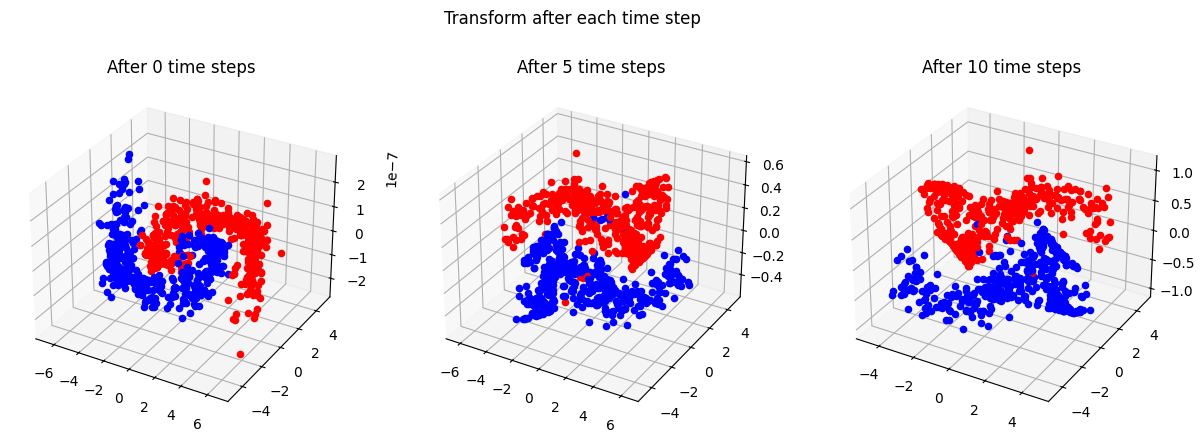

In [577]:
# 3D

# Plot
num_col = 3
fig, axs = plt.subplots(1, num_col,figsize=(15, 5),subplot_kw=dict(projection='3d'))

for l in range(num_col): # Hidden layers # Time step
    
    if l == num_col - 1: # Always plot end
        l_plot = x_transformed_reduced.shape[-1] - 1 
    else:
        l_plot = x_transformed_reduced.shape[-1] // (num_col - 1) * l # plot every num_col step

    # fit agian for each time step
    # FIXME: pca_result = x_transformed_reduced[:, :, l_plot] hvis vi allerede har 3d
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(x_transformed_reduced[:, :, l_plot])
    
    
    for i in range(pca_result.shape[0]): # # num samples in each batch
        # 3D
        axs[l].scatter(pca_result[i, 0], pca_result[i, 1], pca_result[i, 2], ".", c=label_to_color[y_transformed_reduced[i]])
        
    axs[l].set_title(f"After {l_plot} time steps")
    # axs[h].contourf(x_grid, y_grid, prediction.reshape(80, 80))
plt.suptitle("Transform after each time step")
plt.show()

Interactive 3D plot

In [578]:
pca = PCA(n_components=3)
x_start = pca.fit_transform(x_transformed_reduced[:, :, 0])
x_end = pca.fit_transform(x_transformed_reduced[:, :, -1])

c_list = y_transformed_reduced

# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, 
    cols=2,
    specs=[[{'type': 'scene'},
            {'type': 'scene'},]],
    subplot_titles=('Start t=t_0',  'End t=t_n'))


fig.add_trace(
    go.Scatter3d(
        x=x_start[:, 0],
        y=x_start[:, 1],
        z=x_start[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=[label_to_color[c] for c in c_list],                # set color to an array/list of desired values
            # colorscale='Viridis',   # choose a colorscale
            # opacity=0
            ),
        ),
    row=1, 
    col=1,
    )

fig.add_trace(
    go.Scatter3d(
        x=x_end[:, 0],
        y=x_end[:, 1],
        z=x_end[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=[label_to_color[c] for c in c_list],                # set color to an array/list of desired values
            # colorscale='Viridis',   # choose a colorscale
            # opacity=0
            ),
        ),
    row=1, 
    col=2,
    )

fig.update_layout(
    title="Transformation of points"
)
fig.show()

### Plot 2D reverse input layer to construct original dimension # gir ikke mening, men sier hvordan modelen tror input set ut

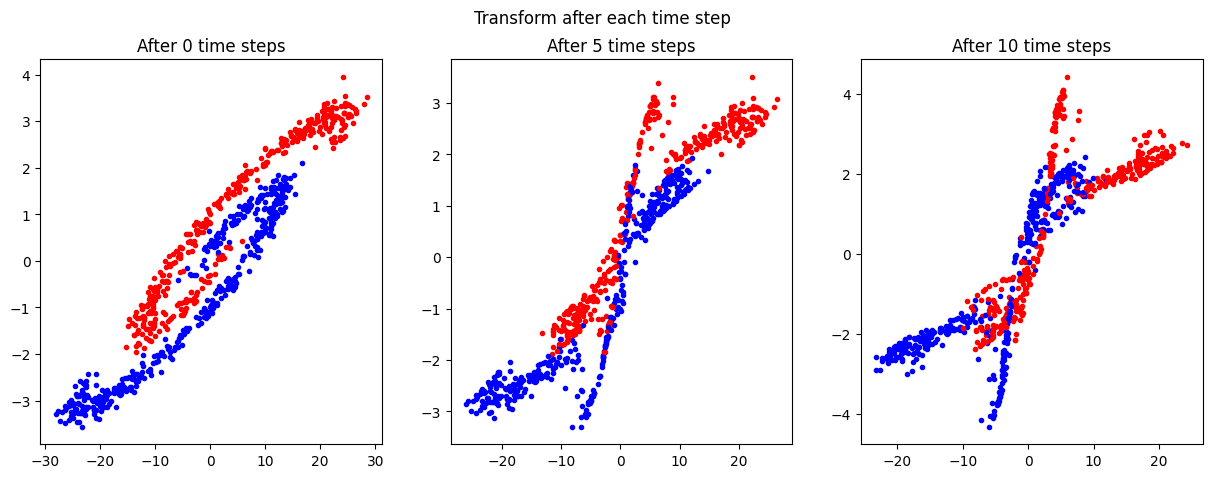

In [576]:
# Plot

num_col = 3
fig, axs = plt.subplots(1, num_col, figsize=(15, 5))  
for b in range(len(x_transformed_array)): # num batches
    
    # Get output for each batch
    x_trans = x_transformed_array[b]
    
    # Reconstruct by inverse the data through the input layer (i.e, reduce dimension in similar manner as we upscale)
    x_reconstructed = torch.matmul(model.input_layer.weight.t(), x_trans).detach().numpy()
    # x_reconstructed.shape : # samples in each batch - # coordinates - # time step layer
    
    for h in range(num_col): # hidden layers ( time step layer )
        if h == num_col - 1: # Always plot end
            h1 = x_trans.shape[2] - 1
        else:
            h1 = x_trans.shape[2] // (num_col - 1) * h # plot every num_col step
            
        for i in range(x_trans.shape[0]): # # num samples in each batch
            # 2D
            axs[h].plot(x_reconstructed[i, 0, h1], x_reconstructed[i, 1, h1], ".", c=label_to_color[y_transformed_narray[b, i]])
        
        axs[h].set_title(f"After {h1} time steps")
        # axs[h].contourf(x_grid, y_grid, prediction.reshape(80, 80))
plt.suptitle("Transform after each time step")
plt.show()

### Plot 2D with PCA to reduce dimension

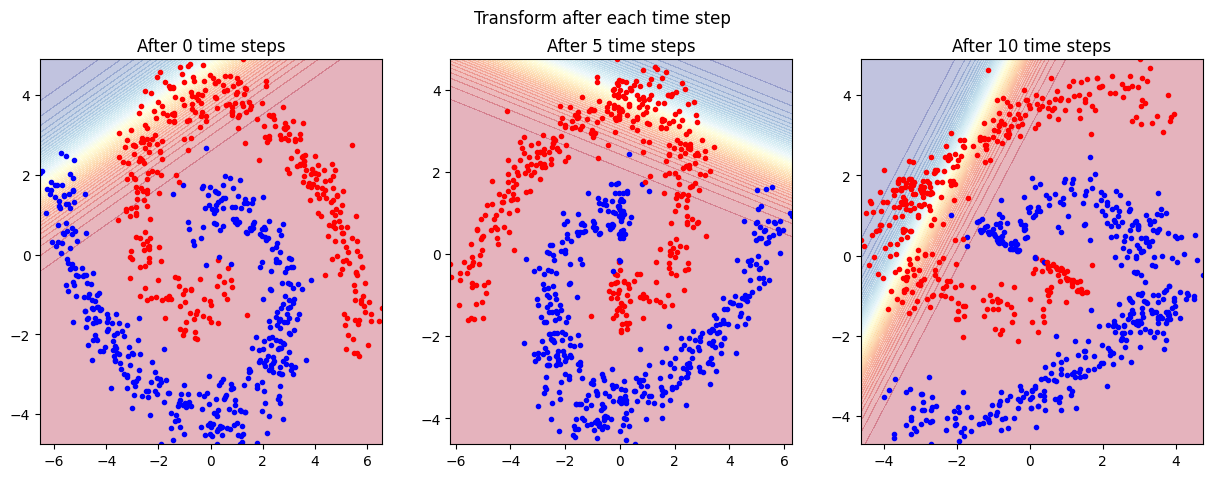

In [582]:
# Plot

# Use PCA to reduce dimension
# NOTE: Dim need to be 2 in order to plot trajectory
pca = PCA(n_components=2)
# ex.: pca_result = pca.fit_transform(x_transformed_array[0, :, :, 0])
# pca_result.shape : # num samples in each batch - # dimension (2)

num_col = 3

fig, axs = plt.subplots(1, num_col, figsize=(15, 5))  


for l in range(num_col): # Hidden layers # Time step
    
    if l == num_col - 1: # Always plot end
        l_plot = x_transformed_reduced.shape[-1] - 1 
    else:
        l_plot = x_transformed_reduced.shape[-1] // (num_col - 1) * l # plot every num_col step

    # Fit at first layer only
    # if l == 0:
    #    pca_result = pca.fit(x_transformed_reduced[:, :, l_plot])
    
    
    # fit agian for each time step
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(x_transformed_reduced[:, :, l_plot])
    
    for i in range(pca_result.shape[0]): # # num samples in each batch
        axs[l].plot(pca_result[i, 0], pca_result[i, 1], ".", c=label_to_color[y_transformed_reduced[i]])

    axs[l].set_title(f"After {l_plot} time steps")
    
    # ------------------------------- background contourf plot ----------------------------
    
    x_min = pca_result[:, 0].min()
    x_max = pca_result[:, 0].max()
    y_min = pca_result[:, 1].min()
    y_max = pca_result[:, 1].max()

    # create grid for prediction as coloured background
    x_grid, y_grid = np.meshgrid(
        np.linspace(x_min, x_max, 1000),
        np.linspace(y_min, y_max, 1000)
        )
    XGrid = torch.tensor(list(zip(x_grid.flatten(), y_grid.flatten()))).float()

    # inverse transform to match internal dimension
    XGrid_original = pca.inverse_transform(XGrid)
    XGrid_original = torch.tensor(XGrid_original).float()

    # apply linear classifier and logits to prob
    model.eval()
    #prediction = model.logits_to_prob(model.classifier(XGrid_original)).squeeze().detach().numpy()
    prediction = model.logits_to_prob(model.classifier(XGrid_original)).squeeze().detach().numpy()


    axs[l].contourf(x_grid, y_grid, prediction.reshape(1000, 1000), levels=50, cmap=plt.cm.RdYlBu_r, alpha=0.3)

    # ------------------------------- background contourf plot ----------------------------

plt.suptitle("Transform after each time step")
plt.show()

## Loss, accuracy and confusion matrix

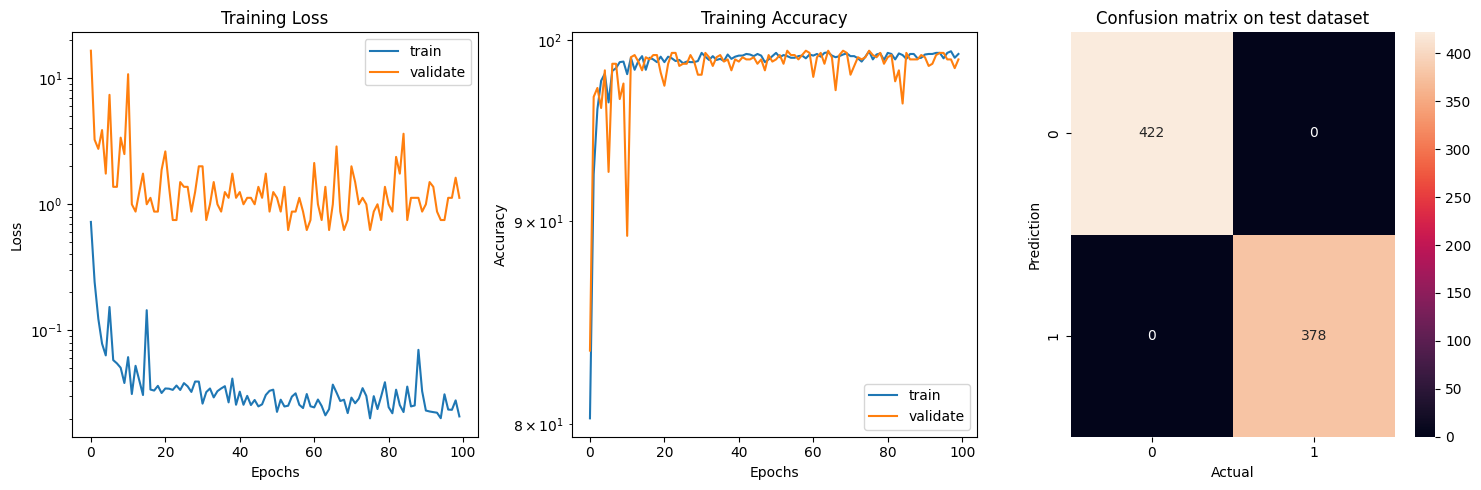

In [599]:


# Plot loss
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(train_loss_per_epoch, label="train")
axs[0].plot(test_loss_per_epoch, label="validate")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(train_acc_per_epoch, label="train")
axs[1].plot(test_acc_per_epoch, label="validate")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training Accuracy")
axs[1].set_yscale("log")
axs[1].legend()

# compute the confusion matrix
cm = confusion_matrix(y_test, y_data)

#Plot the confusion matrix.
axs[2] = sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['0', '1'], # FIXME: change to red and blue
            yticklabels=['0', '1'])
axs[2].set_ylabel('Prediction')
axs[2].set_xlabel('Actual')
axs[2].set_title("Confusion matrix on test dataset")
plt.tight_layout()
plt.show()